In [1]:
# !. /vol/cuda/11.4.120-cudnn8.2.4/setup.sh
# ! nvcc --version

In [10]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax.config import config

from inducing_points import random_select

config.update("jax_enable_x64", True)
%matplotlib inline

In [11]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

# Inducing inputs
# X_m = jnp.linspace(-0.4, 0.4, m).reshape(-1, 1)
X_m = random_select(X, 30)

X.shape, y.shape, X_m.shape, X_test.shape, f_true.shape

((1000, 1), (1000, 1), (30, 1), (1000, 1), (1000, 1))

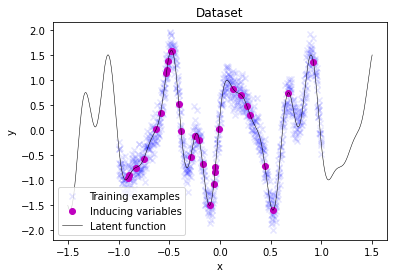

In [12]:
plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.scatter(X_m, func(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [16]:
from models import FCN
from neural_tangents import stax
from snngp import SNNGP

model = FCN
model_params = dict(
            kernel_batch_size=0, 
            device_count=-1, 
            num_layers=2, 
            hid_dim=1024, 
            out_dim=10, 
            nonlinearity=stax.Relu
            )

snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=X_m, num_latent_gps=1)

snngp.lower_bound(), snngp.upper_bound(), snngp.evaluate()

(DeviceArray(-1252.01390695, dtype=float64),
 DeviceArray(-1249.22465303, dtype=float64),
 DeviceArray(2.78925392, dtype=float64))

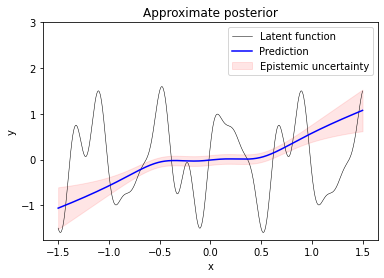

In [17]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)
f_test_std = np.sqrt(f_test_cov)

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(None, 3.0)
plt.legend()

In [18]:
opt_params = snngp.optimize()
snngp.lower_bound(), snngp.upper_bound(), snngp.evaluate()

(DeviceArray(-1029.53448506, dtype=float64),
 DeviceArray(-967.93427719, dtype=float64),
 DeviceArray(61.60020787, dtype=float64))

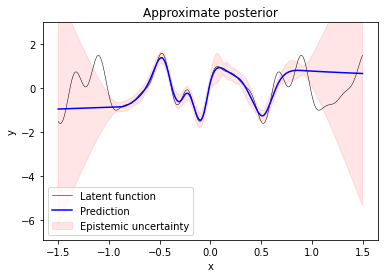

In [19]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)
f_test_std = np.sqrt(f_test_cov)

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(None, 3.0)
plt.legend()

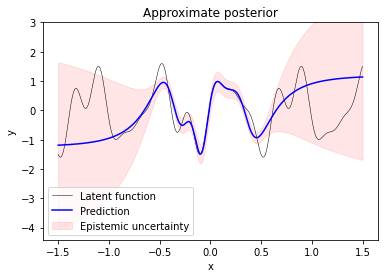

In [7]:
# f_test, f_test_cov = snngp.predict1(X_test, opt_params)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)

# plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
# plt.plot(X_test, f_test, label='Prediction', c='b')
# plt.fill_between(X_test.ravel(), 
#                  f_test.ravel() + 2 * f_test_std, 
#                  f_test.ravel() - 2 * f_test_std,
#                  label='Epistemic uncertainty',
#                  color='r', alpha=0.1)
# plt.title('Approximate posterior')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.ylim(None, 3.0)
# plt.legend()

In [9]:
var = np.array([[1,2],[3,4]])
var1 = var[None, ...]
var1 = np.tile(var1, [3, 1, 1])
var, var1

(array([[1, 2],
        [3, 4]]),
 array([[[1, 2],
         [3, 4]],
 
        [[1, 2],
         [3, 4]],
 
        [[1, 2],
         [3, 4]]]))

In [10]:
var.shape, var[None, ...].shape, var1.shape

((2, 2), (1, 2, 2), (3, 2, 2))

In [14]:
np.diag(var)[:, None].shape, np.tile(np.diag(var)[:, None], [1, 3]).shape

((2, 1), (2, 3))